In [1]:
import pandas as df
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

ModuleNotFoundError: No module named 'modules'

## Preprocess the data

In [2]:
Directory = 'data'
u_ds = utils.concatenate_time(Directory, 'u')
v_ds = utils.concatenate_time(Directory, 'v')
w_ds = utils.concatenate_time(Directory, 'w')
theta_ds = utils.concatenate_time(Directory, 'theta')
assert u_ds.shape == v_ds.shape == w_ds.shape == theta_ds.shape, 'u,v,w,theta have different shape'

In [3]:
wtheta_ds = w_ds*theta_ds

In [4]:
def coarse_array(ds, L):
    '''
    ## Description
    Coarsen a dataset over the altitude and time axis.
    The new shape is (time, altitude, y, x) where y and x are divided by L.

    ## Parameters
    - ds (np array) : dataset to coarsen
    - L (int) : coarsening factor
    '''
    #initialize coarse array
    coarse_ds = np.zeros((ds.shape[0], ds.shape[1], int(ds.shape[2]/L), int(ds.shape[3]/L)))
    for t in range(ds.shape[0]):
        for z in range(ds.shape[1]):
            for i in range(int(ds.shape[2]/L)):
                for j in range(int(ds.shape[3]/L)):
                    coarse_ds[t,z,i,j] = np.mean(ds[t,z,i*L:(i+1)*L,j*L:(j+1)*L])
    return coarse_ds

In [5]:
u_coarse = utils.coarse_array(u_ds, 32)
u_coarse.shape

(1, 4, 16, 16)

In [6]:
# get vector of altitudes for each y,x point
u_samples = np.zeros((u_coarse.shape[0]*u_coarse.shape[2]*u_coarse.shape[3], u_coarse.shape[1]))

for t in range(u_coarse.shape[0]):
    for i in range(u_coarse.shape[2]):
        for j in range(u_coarse.shape[3]):
            u_samples[t*u_coarse.shape[2]*u_coarse.shape[3] + i*u_coarse.shape[3] + j] = u_coarse[t,:,i,j]


In [7]:
def var_samples(ds,L):
    '''
    ## Description
    Get the samples of a dataset over the altitude axis.
    The new shape is (time, y, x) where y and x are divided by L.

    ## Parameters
    - ds (np array) : dataset to coarsen
    - L (int) : coarsening factor
    '''
    #initialize coarse array
    ds_coarse = coarse_array(ds, L)
    samples = np.zeros((ds_coarse.shape[0]*ds_coarse.shape[2]*ds_coarse.shape[3], ds_coarse.shape[1]))
    for t in range(ds_coarse.shape[0]):
        for i in range(ds_coarse.shape[2]):
            for j in range(ds_coarse.shape[3]):
                samples[t*ds_coarse.shape[2]*ds_coarse.shape[3] + i*ds_coarse.shape[3] + j] = ds_coarse[t,:,i,j]
    return samples

In [8]:
utils.variable_samples(u_ds, 32)

array([[14.9804707 , 14.99043066, 15.00086523, 15.00930762],
       [14.8064375 , 14.82397559, 14.84153613, 14.8614502 ],
       [14.9475625 , 14.96709766, 14.98912402, 15.0123125 ],
       ...,
       [14.7393252 , 14.75418555, 14.76291113, 14.76828418],
       [14.69826953, 14.71771484, 14.73111426, 14.7410918 ],
       [14.42030859, 14.43687695, 14.45350586, 14.46567773]])

In [9]:
def input_dataset(dir,variables,L):
    '''
    ## Description
    Create a dataset of the variables in the list variables.
    The new shape is (time*y*x, altitude*nbvar).

    ## Parameters
    - dir (str) : directory where the data is stored
    - variables (list) : list of variables to include in the dataset
    - L (int) : coarsening factor
    '''
    l = len(variables)
    assert l!=0, 'variables list is empty'
    #initialize dataset
    ds = var_samples(utils.concatenate_time(dir, variables[0]), L)
    for var in range(1,l):
        ds = np.concatenate((ds,var_samples(utils.concatenate_time(dir, variables[var]),L)), axis=1)
    return ds

In [10]:
variables = ['u', 'v', 'w', 'theta']
input_ds = utils.input_dataset(Directory, variables, 32)

In [11]:
input_ds.shape

(256, 16)

In [12]:
output_ds = utils.variable_samples(wtheta_ds, 32)

In [13]:
output_ds.shape

(256, 4)

In [14]:
tot_ds = np.concatenate((input_ds, output_ds), axis=1)
tot_ds.shape

(256, 20)

## First NN

In [51]:
# define a three layer linear neural network with one hidden layer, input size is 16 and output size is 4
class LinNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

learning_rate = 0.001
model = LinNet(16,32,4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
# split input_ds and output_ds into training and validation sets
train, test = utils.split_train_val(tot_ds)
input_train, output_train, input_val, output_val = train[:,:16], train[:,16:], test[:,:16], test[:,16:]
input_val.shape
#tot_ds.shape

(64, 16)

In [29]:
input = torch.from_numpy(input_train).float()
output = torch.from_numpy(output_train).float()
input_batch = input[batch_size:2*batch_size,:]
output_batch = output[batch_size:2*batch_size,:]
F.mse_loss(model(input_batch), output_batch, reduction='sum')

tensor(1.9449, grad_fn=<MseLossBackward>)

In [52]:
# train the model
nb_epochs = 100
losses=[]
batch_size = 32
model.train()

for epoch in range(nb_epochs):
    tot_losses=0
    for i in np.random.permutation(input_train.shape[0]//batch_size):
        # convert numpy array to torch tensor
        input = torch.from_numpy(input_train).float()
        output = torch.from_numpy(output_train).float()
        loss=0

        input_batch = input[i*batch_size:(i+1)*batch_size,:]
        output_batch = output[i*batch_size:(i+1)*batch_size,:]
        optimizer.zero_grad()
        # forward pass
        output_pred = model(input_batch)
        # compute loss
        loss += F.mse_loss(output_pred, output_batch, reduction='sum')
        tot_losses += loss.item()
        # backward pass
        loss.backward()
        optimizer.step()
    losses.append(tot_losses/(input_train.shape[0]//batch_size))
    if (epoch+1)%10==0:
        print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch+1, nb_epochs, tot_losses/(input_train.shape[0]//batch_size)))

Epoch [10/100], Loss: 3.018055
Epoch [20/100], Loss: 2.579090
Epoch [30/100], Loss: 2.054344
Epoch [40/100], Loss: 1.196923
Epoch [50/100], Loss: 0.195739
Epoch [60/100], Loss: 0.025092
Epoch [70/100], Loss: 0.006778
Epoch [80/100], Loss: 0.005000
Epoch [90/100], Loss: 0.003864
Epoch [100/100], Loss: 0.003124


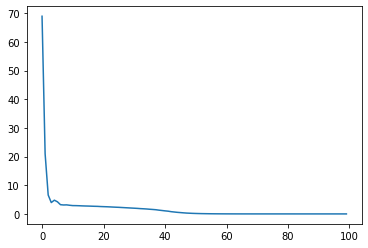

In [55]:
plt.plot(losses)

In [56]:
# test the model

# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()
predictions= torch.zeros(output_test.shape)
tot_losses=0

model.eval()
# prediction
output_pred = model(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum')

print('Test loss: {:.6f}'.format(loss*batch_size/input_test.shape[0]))

Test loss: 0.003003


In [57]:
print(output_pred[:5])
print(output_test[:5])

tensor([[-0.1718, -0.1762, -0.1793, -0.1852],
        [-0.1489, -0.1460, -0.1535, -0.1595],
        [-0.0096, -0.0031, -0.0083, -0.0073],
        [-0.0275, -0.0156, -0.0251, -0.0280],
        [-0.1305, -0.1288, -0.1351, -0.1352]], grad_fn=<SliceBackward>)
tensor([[-0.1735, -0.1757, -0.1778, -0.1801],
        [-0.1394, -0.1469, -0.1540, -0.1610],
        [-0.0024, -0.0060, -0.0095, -0.0128],
        [-0.0281, -0.0260, -0.0238, -0.0213],
        [-0.1238, -0.1304, -0.1370, -0.1435]])


In [22]:
# define a three layer convolutional neural network with one hidden layer, input size is 16 and output size is 4

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2)
        #x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x